In [139]:
# Parameters
import numpy as np
import matplotlib.pyplot as plt



rho_a = 1600 #kg/m^3
# active and frozen soil probably have similar densities, with frozen having more water content

rho_p = 2000
rho_w = 1000
K_a = 1e-3 
# frozen soil has very low permeability
K_p = 1e-6 
g = 9.81



In [153]:
# Discretization
layers = 10
layers_x = 5
dx = dy = 1.0  # Distance between layers in meters
dt = 1.0  # Time step in seconds
total_time = 10000000  # Total simulation time in seconds
A = 1.0 * dy #assume width of 1 meter 


# Initialize depth, pressure, and permeability arrays
depths = np.arange(0, layers * dy, dy)  
ov_pressures = np.full((layers, layers_x), np.nan)
pw_pressures = np.full((layers, layers_x), np.nan)
K = np.zeros((layers, layers_x))
Q_x = np.zeros((layers, layers_x))
Q_y = np.zeros((layers, layers_x))

In [154]:
# Geometry
al_wl_boundary = int(4)
wl_pl_boundary = int(7)


# given some angle
# h(j) = H - xtan(theta)
slope_height = al_wl_boundary 
theta = 50
theta_radians = np.radians(theta)


In [155]:
# Initial Lithostatic Pressure Distribution
for j in range(layers_x):
    for i in range(layers):
        adjusted_height = slope_height - (j * np.tan(theta_radians))
        if i >= adjusted_height:  # Only apply pressures below the adjusted height
            actual_depth = depths[i] - adjusted_height
            al_pressure = rho_a * g * actual_depth
            # Active layer
            if i <= al_wl_boundary:
                ov_pressures[i, j] = al_pressure
                K[i, j] = K_a
            # Water Layer
            elif al_wl_boundary < i <= wl_pl_boundary:
                ov_pressures[i, j] = rho_w * g * (depths[i] - depths[al_wl_boundary]) + al_pressure
                K[i, j] = 1e-1
            # Permafrost layer
            else:
                wl_pressure = rho_w * g * (depths[wl_pl_boundary] - depths[al_wl_boundary])
                ov_pressures[i, j] = rho_p * g * (depths[i] - depths[wl_pl_boundary]) + wl_pressure + al_pressure
                K[i, j] = K_p

In [156]:
# Initialize Pore water pressures
for i in range(layers):
    for j in range(layers_x):
        adjusted_height = slope_height - (j * np.tan(theta_radians))
        if i > adjusted_height:  # Only apply pressures below the adjusted height
            # Active layer, slightly moist but unsaturated soil has negative pressure
            if i <= al_wl_boundary:
                pw_pressures[i, j] = -100
            # Water layer
            elif i > al_wl_boundary and i <= wl_pl_boundary:
                pw_pressures[i, j] = rho_w*g * (i - al_wl_boundary)
            # Permafrost layer, assuming unsaturated also?
            else:
                #pw_pressures[i, j] = rho_w * g * (i - wl_pl_boundary)
                pw_pressures[i, j] = -100

In [126]:
# Check initialized pressures
np.set_printoptions(precision=2, floatmode='fixed')
print(pw_pressures)

[[     nan      nan      nan      nan  -100.00]
 [     nan      nan      nan  -100.00  -100.00]
 [     nan      nan  -100.00  -100.00  -100.00]
 [     nan  -100.00  -100.00  -100.00  -100.00]
 [     nan  -100.00  -100.00  -100.00  -100.00]
 [ 9810.00  9810.00  9810.00  9810.00  9810.00]
 [19620.00 19620.00 19620.00 19620.00 19620.00]
 [29430.00 29430.00 29430.00 29430.00 29430.00]
 [39240.00 39240.00 39240.00 39240.00 39240.00]
 [ -100.00  -100.00  -100.00  -100.00  -100.00]]


In [127]:
print(ov_pressures)

[[      nan       nan       nan       nan  12039.06]
 [      nan       nan       nan   9029.29  27735.06]
 [      nan       nan   6019.53  24725.29  43431.06]
 [      nan   3009.76  21715.53  40421.29  59127.06]
 [     0.00  18705.76  37411.53  56117.29  74823.06]
 [ 25506.00  44211.76  62917.53  81623.29 100329.06]
 [ 51012.00  69717.76  88423.53 107129.29 125835.06]
 [ 76518.00  95223.76 113929.53 132635.29 151341.06]
 [102024.00 120729.76 139435.53 158141.29 176847.06]
 [137340.00 156045.76 174751.53 193457.29 212163.06]]


In [157]:
# Solver Loop: Darcy Flow and Update Pressure
should_continue = True # Flag to exit loop 
cell_volume = dx * dy

for t in np.arange(0, total_time, dt):
    # Calculate flow rates between layers based on Darcy's Law, depends on pore pressure grad
    Q = np.zeros(layers - 1)
    for i in range(1, layers):
        if not should_continue:
            break
            
        for j in range(1, layers_x):
            if np.isnan(pw_pressures[i, j]) or np.isnan(pw_pressures[i, j-1]):
                Q_x[i-1, j] = 0 
            else: 
                pore_grad_x = (pw_pressures[i,j] - pw_pressures[i,j-1]) / dx
                Q_x[i-1, j] = -K[i, j] * A * pore_grad_x / (rho_w *g)

            if np.isnan(pw_pressures[i, j]) or np.isnan(pw_pressures[i-1, j]):
                Q_y[i, j-1] = 0  
            else:
                pore_grad_y = (pw_pressures[i, j] - pw_pressures[i-1, j]) / dy
                Q_y[i, j-1] = -K[i, j] * A * pore_grad_y / (rho_w *g)
                
            if pw_pressures[i,j] >= ov_pressures[i,j]:
                print(f"Simulation stopped early at time {t}s. Pore water pressure exceeds lithostatic pressure at layer {i}.Pore water pressure is {pw_pressures[i,j]} and overburden {ov_pressures[i,j]}")
                should_continue = False
                break
    # Update pressures based on flow rates
    for i in range(1, layers-1):
        if not should_continue:
            break
        for j in range(1, layers_x):
            if not np.isnan(pw_pressures[i, j]):
                net_flow_x = Q_x[i, j-1] - Q_x[i, j]
                net_flow_y = Q_y[i-1, j] - Q_y[i, j]
                volume_change = (net_flow_x + net_flow_y) * dt
                
                pw_pressures[i, j] += volume_change / cell_volume
            if pw_pressures[i,j] >= ov_pressures[i,j]:
                print(f"Simulation stopped early at time {t}s. Pore water pressure exceeds lithostatic pressure at layer {i}. Pore water pressure is {pw_pressures[i,j]} and overburden {ov_pressures[i,j]}")
                should_continue = False 
                break
            # Check if pore water pressure exceeds lithostatic pressure

    # Break out of the outer loop if the condition is met in any layer
    #break


Simulation stopped early at time 133602.0s. Pore water pressure exceeds lithostatic pressure at layer 7. Pore water pressure is 95223.86070752893 and overburden 95223.76438935871


In [31]:
print(pw_pressures)

[[   nan    nan    nan    nan    nan]
 [   nan    nan    nan    nan  -100.]
 [   nan    nan  -100.  -100.  -100.]
 [   nan  -100.  -100.  -100.  -100.]
 [ 9810.  9810.  9810.  9810.  9810.]
 [19620. 19620. 19620. 19620. 19620.]
 [29430. 29430. 29430. 29430. 29430.]
 [ -100.  -100.  -100.  -100.  -100.]
 [ -100.  -100.  -100.  -100.  -100.]
 [ -100.  -100.  -100.  -100.  -100.]]


In [18]:
pw_pressures[:10]

array([[            nan,             nan,             nan,
                    nan,             nan],
       [            nan,             nan,             nan,
                    nan, -1.00707626e+02],
       [            nan,             nan, -1.66089727e+02,
        -1.53034631e+01, -1.33275128e+02],
       [            nan,  1.03413532e+04, -7.85622748e+03,
        -6.14825616e+03, -8.29965877e+03],
       [ 9.81000000e+03,  2.99384397e+04,  4.26997357e+04,
         2.91006207e+04,  4.19424808e+03],
       [ 1.96200000e+04, -4.42933312e+03, -6.95555515e+03,
         2.07839923e+04,  2.28024592e+04],
       [ 2.94300000e+04,  5.56633541e+04,  3.74711263e+04,
         2.71743564e+04,  2.94300625e+04],
       [-1.00000000e+02, -2.10205909e+04, -1.17396454e+04,
        -1.12568804e+04, -1.00000002e+02],
       [-1.00000000e+02, -9.94899855e+01, -9.95212341e+01,
        -9.96456398e+01, -1.00000000e+02],
       [-1.00000000e+02, -1.00000000e+02, -1.00000000e+02,
        -1.00000000e+02

In [27]:
print(ov_pressures)

[[           nan            nan            nan            nan
             nan]
 [           nan            nan            nan            nan
   10839.6406992]
 [           nan            nan  28963.8203496  19901.7305244
   10839.6406992]
 [           nan  38025.9101748  28963.8203496  19901.7305244
   10839.6406992]
 [ 56898.         47835.9101748  38773.8203496  29711.7305244
   20649.6406992]
 [ 66708.         57645.9101748  48583.8203496  39521.7305244
   30459.6406992]
 [ 76518.         67455.9101748  58393.8203496  49331.7305244
   40269.6406992]
 [ 96138.         87075.9101748  78013.8203496  68951.7305244
   59889.6406992]
 [115758.        106695.9101748  97633.8203496  88571.7305244
   79509.6406992]
 [135378.        126315.9101748 117253.8203496 108191.7305244
   99129.6406992]]


In [28]:
print(ov_pressures)

[[           nan            nan            nan            nan
             nan]
 [           nan            nan            nan            nan
   10839.6406992]
 [           nan            nan  28963.8203496  19901.7305244
   10839.6406992]
 [           nan  38025.9101748  28963.8203496  19901.7305244
   10839.6406992]
 [ 56898.         47835.9101748  38773.8203496  29711.7305244
   20649.6406992]
 [ 66708.         57645.9101748  48583.8203496  39521.7305244
   30459.6406992]
 [ 76518.         67455.9101748  58393.8203496  49331.7305244
   40269.6406992]
 [ 96138.         87075.9101748  78013.8203496  68951.7305244
   59889.6406992]
 [115758.        106695.9101748  97633.8203496  88571.7305244
   79509.6406992]
 [135378.        126315.9101748 117253.8203496 108191.7305244
   99129.6406992]]


In [158]:
effective_stress = ov_pressures - pw_pressures

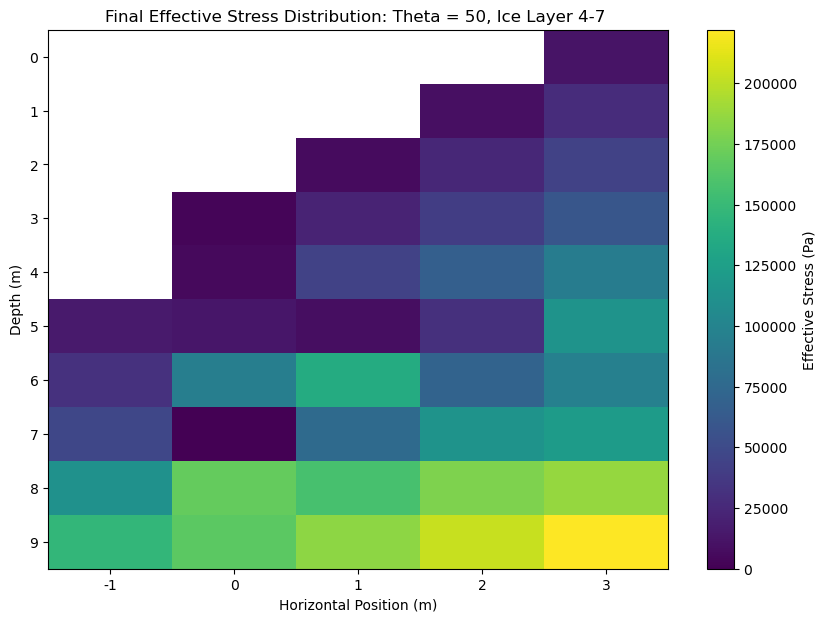

In [159]:
plt.figure(figsize=(10, 7))

# Heatmap of effective stress
plt.imshow(effective_stress, cmap='viridis', interpolation='nearest', aspect='auto')
plt.colorbar(label='Effective Stress (Pa)')

plt.title('Final Effective Stress Distribution: Theta = 50, Ice Layer 4-7 ')
plt.xlabel('Horizontal Position (m)')
plt.ylabel('Depth (m)')
# Assuming equally spaced horizontal positions and depth layers for labels
plt.xticks(np.arange(effective_stress.shape[1]), labels=[f'{i-1}' for i in range(effective_stress.shape[1])])
plt.yticks(np.arange(effective_stress.shape[0]), labels=[f'{i}' for i in range(effective_stress.shape[0])])

#plt.gca().invert_yaxis()  # Invert y-axis to have the top of the soil column at the top of the plot
plt.savefig('/Users/samanthahordyk/Desktop/init_effective_stress_distribution_fourtoseven50deg.png', dpi=300)
plt.show()